In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r'C:\Users\Mohamed Fawzi\Desktop\Warehouse Sales\Warehouse_and_Retail_Sales.csv')

df.head(2)

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.0,0.0,2.0
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.0,1.0,4.0


# Cleaning & Preparing The Data

In [2]:
# I will convert all columns name to be title case - I prefer it like that :)
df.columns = df.columns.str.title()

In [5]:
# drop null values
df.dropna(inplace=True)

In [6]:
df.isna().sum()

Year                0
Month               0
Supplier            0
Item Code           0
Item Description    0
Item Type           0
Retail Sales        0
Retail Transfers    0
Warehouse Sales     0
dtype: int64

In [ ]:
# exclude 'STR_SUPPLIES', 'KEGS', 'REF', 'DUNNAGE', because most of the values are zeros
df = df[df['Item Type'].isin(['WINE', 'BEER', 'LIQUOR','NON-ALCOHOL'])]

In [8]:
df['Item Type'].unique()


array(['WINE', 'BEER', 'LIQUOR', 'NON-ALCOHOL'], dtype=object)

In [9]:
# Calculate mean values for only saleable items
saleable_items = ['WINE', 'BEER', 'LIQUOR', 'NON-ALCOHOL']  # Define saleable items
mean_values = df[df['Item Type'].isin(saleable_items)].groupby('Item Type')[['Warehouse Sales', 'Retail Transfers', 'Retail Sales']].mean()

# Define a function to replace zeros
def replace_zeros_with_mean(row, mean_values):
    item_type = row['Item Type']
    for col in ['Warehouse Sales', 'Retail Transfers', 'Retail Sales']:
        if row[col] == 0.0 and item_type in mean_values.index:
            row[col] = mean_values.loc[item_type, col]  # Replace zero with mean for this item type
    return row

# Apply the function to rows where the item type is saleable
df = df.apply(replace_zeros_with_mean, mean_values=mean_values, axis=1)

In [10]:
df.sample()

,Year,Month,Supplier,Item Code,Item Description,Item Type,Retail Sales,Retail Transfers,Warehouse Sales
303756,2020,9,CAMPARI AMERICA LLC,44431,APEROL 6/CS - 750ML,LIQUOR,139.13,137.0,14.0


In [12]:
# converting the Year & Month to datetime
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296862 entries, 0 to 307644
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Year              296862 non-null  int64         
 1   Month             296862 non-null  int64         
 2   Supplier          296862 non-null  object        
 3   Item Code         296862 non-null  object        
 4   Item Description  296862 non-null  object        
 5   Item Type         296862 non-null  object        
 6   Retail Sales      296862 non-null  float64       
 7   Retail Transfers  296862 non-null  float64       
 8   Warehouse Sales   296862 non-null  float64       
 9   Date              296862 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 24.9+ MB


In [13]:
# Convert numeric columns to float
numeric_columns = ['Retail Sales', 'Retail Transfers', 'Warehouse Sales']

df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
#df.info()


In [14]:
# extract month name from the date column that I created earlier
df['Month Name'] = df['Date'].dt.month_name()

# Exploratory Data Analysis (EDA):

## Time Series Trend

In [15]:
monthly_sales = df.groupby('Month Name')[['Warehouse Sales', 'Retail Sales']].sum().reset_index().round(2)

month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# order by month name
monthly_sales['Month Name'] = pd.Categorical(monthly_sales['Month Name'], categories=month_order, ordered=True)
monthly_sales.head(2)

,Month Name,Warehouse Sales,Retail Sales
0,April,325981.52,110407.22
1,August,797203.68,234754.87


In [16]:
# melt the dataframe for plotting.
monthly_sales_melted = monthly_sales.melt(id_vars='Month Name', var_name='Sales Type', value_name='Sales')
monthly_sales_melted.head(2)

,Month Name,Sales Type,Sales
0,April,Warehouse Sales,325981.52
1,August,Warehouse Sales,797203.68


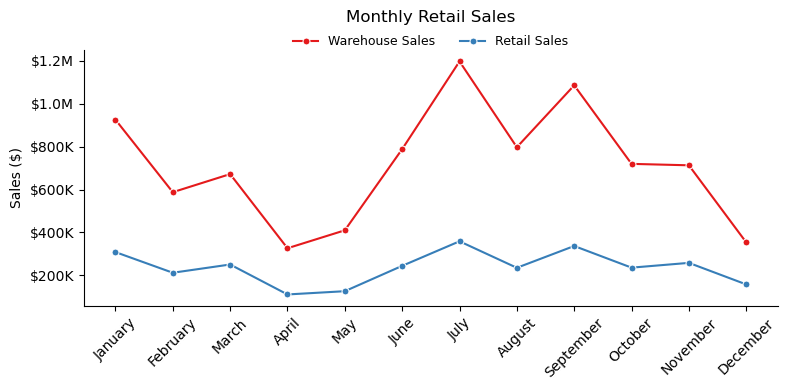

In [17]:
plt.figure(figsize=(8, 4))
sns.lineplot(
            data=monthly_sales_melted,
             x='Month Name',
             y='Sales',
             hue='Sales Type',
             palette='Set1',
             marker='o',
             markersize=5,



        )

def format_currency(x, pos):
    if x >= 1e6:
        return '${:1.1f}M'.format(x*1e-6)
    else:
        return '${:1.0f}K'.format(x*1e-3)

# Apply the currency format to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_currency))

plt.title('Monthly Retail Sales', pad=20)
plt.xlabel('')
plt.ylabel('Sales ($)')

plt.xticks(rotation=45)
plt.legend(ncols=2, loc='upper center', frameon=False, bbox_to_anchor=(0.5, 1.1), fontsize=9)

sns.despine()
plt.tight_layout()
plt.show()


Here are some key insights from the Monthly Retail Sales chart:
-   Warehouse Sales Are Consistently Higher:

    -   Throughout the year, warehouse sales significantly outperform retail sales, often by more than double.

-   Peak Sales Months:

    -   July marks the highest month for warehouse sales (~$1.2M).

    -   Retail sales also peak in July (~$350K), suggesting seasonal or promotional factors affecting both channels.

-   Lowest Sales Periods:

    -   April is the weakest month for both warehouse and retail sales, particularly low for retail (~$100K).

-   Seasonal Trends:

    -   Warehouse sales exhibit more volatility with large spikes (June–July, September).

    -   Retail sales are relatively stable with moderate fluctuations.

-----

### Average Monthly Sales:


In [18]:
# Monthly seasonality pattern
seasonality = df.groupby('Month Name')[['Warehouse Sales', 'Retail Sales']].mean().reset_index().round(2)
seasonality['Month Name'] = pd.Categorical(seasonality['Month Name'], categories=month_order, ordered=True)
seasonality_melted = seasonality.melt(id_vars='Month Name', var_name='Sales Type', value_name='Sales')

seasonality_melted.head(2)

,Month Name,Sales Type,Sales
0,April,Warehouse Sales,26.56
1,August,Warehouse Sales,31.91


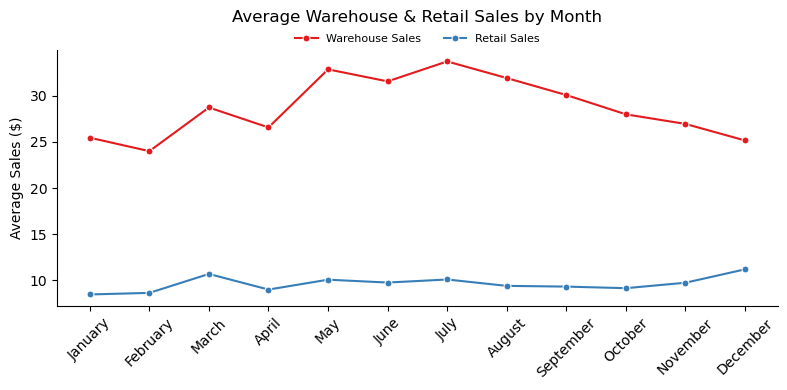

In [19]:
plt.figure(figsize=(8,4))
sns.lineplot(
        data=seasonality_melted,
    x='Month Name',
    y='Sales',
    hue='Sales Type',
        palette='Set1',
        marker='o',
        markersize=5,

)

plt.title('Average Warehouse & Retail Sales by Month', pad=20)
plt.xlabel('')
plt.ylabel('Average Sales ($)')
plt.xticks(rotation=45)

plt.legend(ncols=2, loc='upper center', frameon=False, bbox_to_anchor=(0.5, 1.1), fontsize=8)
sns.despine()
plt.tight_layout()
plt.show()



### **Key Insights**

1. **July Is the Peak for Both Channels**:

   * **Warehouse Sales** peak in **July (\~\$34)**, followed closely by **May and June**.
   * **Retail Sales** also show a smaller peak in **December (\~\$11)** and **March**.

2. **Warehouse Sales Show a Strong Mid-Year Surge**:

   * From **April to July**, there's a noticeable rise in average warehouse sales, suggesting increased B2B demand or bulk purchasing during this period.

3. **Retail Sales Are Steadier But Lower**:

   * Retail sales fluctuate mildly between **\$8 and \$11**, showing more stability but consistently lower values than warehouse sales.

-----



## **Item Type Analysis**

### Item Distribution

Now, let's see how many items fall under each item type to undersatand the distribution of item types in the dataset.

In [20]:
# item counts
df_items = df['Item Type'].value_counts().reset_index()
df_items

,Item Type,count
0,WINE,187640
1,LIQUOR,64910
2,BEER,42413
3,NON-ALCOHOL,1899


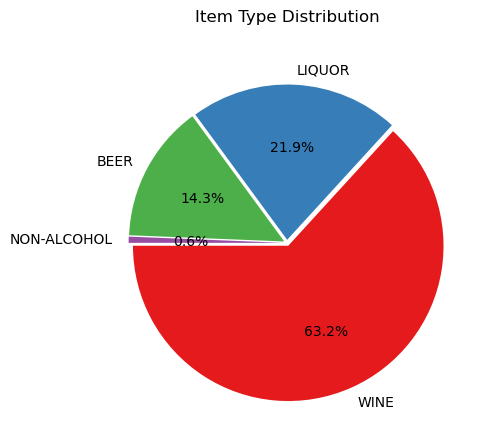

In [23]:
plt.figure(figsize=(5, 5))
plt.pie(
    df_items['count'],
    labels=df_items['Item Type'],
    autopct='%1.1f%%',
    startangle=180,
    colors=sns.color_palette('Set1'),
    explode=[0.02] * len(df_items)
)


plt.title('Item Type Distribution', pad=20)

sns.despine()
plt.tight_layout()
plt.show()

#### **Key Insights:**

1. **Wine Dominates the Product Mix**:

   * **Wine** represents the majority share at **63.2%**, indicating it’s the most stocked or sold item type—likely the primary revenue driver.

2. **Liquor and Beer Have Moderate Shares**:

   * **Liquor** accounts for **21.9%**, showing strong demand.
   * **Beer** holds **14.3%**, rounding out the major alcoholic categories.

3. **Non-Alcoholic Items Are Negligible**:

   * Just **0.6%** of the items fall under the **Non-Alcohol** category, suggesting very limited product variety or sales in this segment.


---


### Sale by Item Type

Let's see the total Warehouse and Retail Sales for each Item Type:


In [24]:
sales_by_item_type = df.groupby('Item Type')[['Warehouse Sales', 'Retail Sales']].sum().reset_index().round(2)
sales_by_item_type = sales_by_item_type.sort_values(by='Warehouse Sales', ascending=False)

sales_by_item_type_melted = sales_by_item_type.melt(id_vars='Item Type', var_name='Sales Type', value_name='Sales')
sales_by_item_type_melted

,Item Type,Sales Type,Sales
0,BEER,Warehouse Sales,6959533.38
1,WINE,Warehouse Sales,1408877.62
2,LIQUOR,Warehouse Sales,170856.14
3,NON-ALCOHOL,Warehouse Sales,36491.00
4,BEER,Retail Sales,880846.95
5,WINE,Retail Sales,1089747.11
6,LIQUOR,Retail Sales,828450.27
7,NON-ALCOHOL,Retail Sales,30681.71


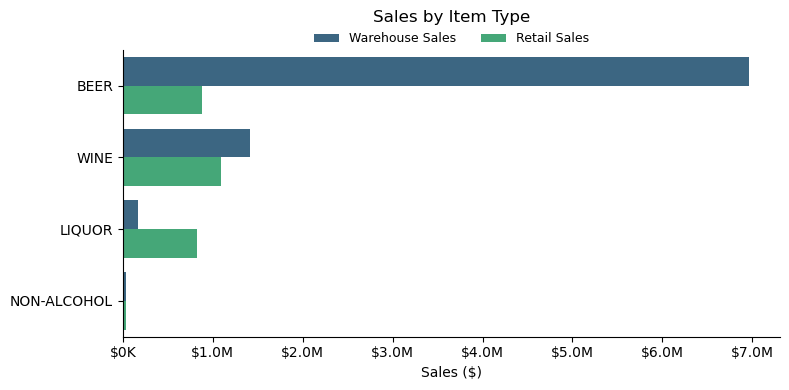

In [25]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=sales_by_item_type_melted,
    x='Sales',
    y='Item Type',
    hue='Sales Type',
    palette='viridis'
)

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_currency)) # the function is defined earlier in the code.

plt.title('Sales by Item Type', pad=20)
plt.xlabel('Sales ($)')
plt.ylabel('')

plt.legend(ncols=2, loc='upper center', frameon=False, bbox_to_anchor=(0.5, 1.1), fontsize=9)

sns.despine()
plt.tight_layout()
plt.show()

#### **Key Insights:**

1. **Beer Drives Warehouse Sales**:

   * **Beer** dominates warehouse sales with nearly **\$7M**, far exceeding all other categories.
   * Indicates a strong B2B demand, possibly from bars, restaurants, or distributors.

2. **Retail Sales Are More Balanced**:

   * **Wine** and **Liquor** perform relatively well in retail, each generating over **\$1M**.
   * Suggests wine and liquor are more popular among direct consumers.

3. **Wine: Stocked Most, But Lower Warehouse Sales**:

   * Despite being **63% of the item mix** (as seen in the pie chart), **wine** contributes modestly to warehouse sales.
   * This imbalance may point to lower B2B demand or higher inventory holding.

4. **Liquor Reverses the Trend**:

   * Although **liquor** was only **21.9%** of the item mix, its **retail sales surpass warehouse sales**, hinting at strong consumer appeal.

5. **Non-Alcoholic Items Are Negligible Across Channels**:

   * Both warehouse and retail sales are minimal, reinforcing the earlier insight that this segment is underrepresented.

---


### Top 10 Revenue-Generating Items

In [26]:
df['Total_Sales'] = df['Retail Sales'] + df['Warehouse Sales']
top_items = df.groupby('Item Description')['Total_Sales'].sum().nlargest(10).reset_index().round(2)
top_items

,Item Description,Total_Sales
0,CORONA EXTRA LOOSE NR - 12OZ,328224.83
1,CORONA EXTRA 2/12 NR - 12OZ,257679.62
2,HEINEKEN LOOSE NR - 12OZ,189711.21
3,HEINEKEN 2/12 NR - 12OZ,162224.15
4,MILLER LITE 30PK CAN - 12OZ,148926.40
5,CORONA EXTRA 4/6 NR - 12OZ,132679.15
6,MODELO ESPECIAL 24 LOOSE NR - 12OZ,121846.80
7,BUD LIGHT 30PK CAN,108615.97
8,HEINEKEN 4/6 NR - 12OZ,105279.69
9,CORONA EXTRA 18PK NR - 12OZ,100786.29


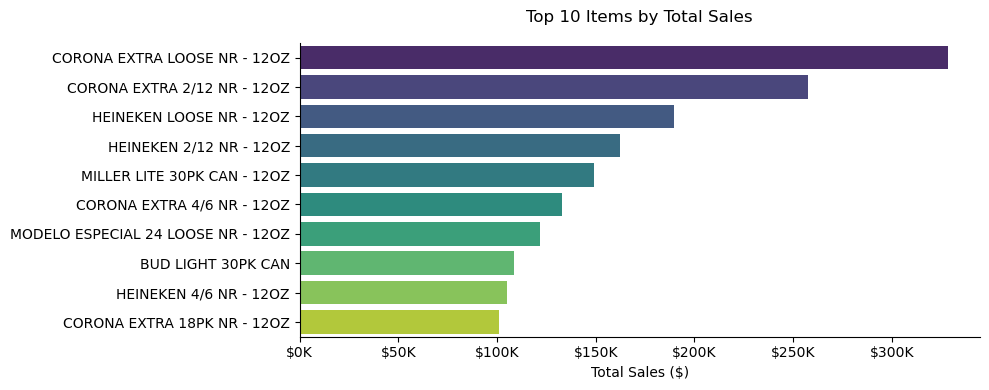

In [27]:
plt.figure(figsize=(10, 4))
sns.barplot(
    data=top_items,
    x='Total_Sales',
    y='Item Description',
    palette='viridis'
)


plt.gca().xaxis.set_major_formatter(FuncFormatter(format_currency)) # the function is defined earlier in the code.

plt.title('Top 10 Items by Total Sales', pad=15)
plt.xlabel('Total Sales ($)')
plt.ylabel('')


sns.despine()
plt.tight_layout()
plt.show()

#### **Key Insights:**

This bar chart shows the **Top 10 Items by Total Sales**, highlighting which products generate the most revenue. Here are the key observations:

---

#### **1. CORONA EXTRA LOOSE NR - 12OZ Dominates Sales**
- **Total Sales**: Approximately **$320,000**.
- **Insight**: This product is the clear leader in total sales, indicating:
  - High demand among consumers.
  - Effective pricing and marketing strategies.
  - Strong brand recognition or loyalty.

#### **2. CORONA EXTRA 2/12 NR - 12OZ Follows Closely**
- **Total Sales**: Around **$250,000**.
- **Insight**: This variant of Corona also performs exceptionally well, suggesting:
  - Consistent consumer preference for Corona products.
  - Different packaging options (e.g., loose vs. 2-pack) cater to diverse customer needs.

#### **3. HEINEKEN Products Show Strong Performance**
- **HEINEKEN LOOSE NR - 12OZ**: Total sales around **$190,000**.
- **HEINEKEN 2/12 NR - 12OZ**: Total sales around **$160,000**.
- **Insight**: Heineken products rank highly, indicating:
  - Strong brand appeal and market penetration.
  - Similar packaging strategies (loose and 2-pack) driving consistent sales.

#### **4. MILLER LITE 30PK CAN - 12OZ Performs Well**
- **Total Sales**: Around **$150,000**.
- **Insight**: This large-pack option (30-pack can) suggests:
  - Bulk purchasing behavior among customers.
  - Competitive pricing or promotions for this format.

#### **5. Other Top Sellers Show Moderate Performance**
- **CORONA EXTRA 4/6 NR - 12OZ**: Total sales around **$130,000**.
- **MODELO ESPECIAL 24 LOOSE NR - 12OZ**: Total sales around **$120,000**.
- **BUD LIGHT 30PK CAN**: Total sales around **$110,000**.
- **MODELO ESPECIAL-2/12 CAN - 12OZ**: Total sales around **$90,000**.
- **COORS LT 30PK CAN - 12OZ**: Total sales around **$80,000**.
- **Insight**: These products demonstrate steady performance, indicating:
  - Established brands with consistent demand.
  - Packaging formats (e.g., 24-loose, 2-pack, 30-pack) catering to different customer preferences.

#### **6. Pack Size Matters**
- **Large-Packs (30PK)**:  
  - **MILLER LITE 30PK CAN - 12OZ**, **BUD LIGHT 30PK CAN**, and **COORS LT 30PK CAN - 12OZ** show strong sales, suggesting bulk purchasing trends.
- **Smaller Packs (2/12, Loose)**:  
  - **CORONA EXTRA 2/12 NR - 12OZ**, **HEINEKEN 2/12 NR - 12OZ**, and **HEINEKEN LOOSE NR - 12OZ** indicate that smaller, more convenient packs also drive significant sales.

---

##  Supplier Performance Analysis

### Top 5 Supliers

Now we'll analyze the top 5 supplier by Warehouse and Retail Sales

In [28]:
top_suppliers = df.groupby('Supplier')[['Warehouse Sales', 'Retail Sales']].sum().reset_index().round(2)

top_suppliers_whs = top_suppliers.sort_values(by='Warehouse Sales', ascending=False).head()

top_suppliers_rs = top_suppliers.sort_values(by='Retail Sales', ascending=False).head()

top_suppliers_rs

,Supplier,Warehouse Sales,Retail Sales
108,E & J GALLO WINERY,206791.06,168177.84
90,DIAGEO NORTH AMERICA INC,175845.86,149495.80
15,ANHEUSER BUSCH INC,1394450.59,134804.49
76,CONSTELLATION BRANDS,124496.31,132605.41
188,LEGENDS LTD,187396.44,116584.09


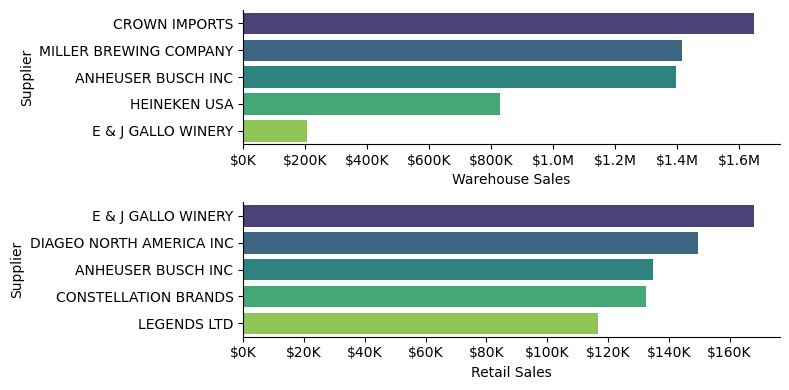

In [29]:
# plotting top_suppliers as subplot
fig, axes = plt.subplots(2, 1, figsize=(8, 4))

sns.barplot(
    data=top_suppliers_whs,
    x='Warehouse Sales',
    y='Supplier',
    palette='viridis',
    ax=axes[0]
)

sns.barplot(
    data=top_suppliers_rs,
    x='Retail Sales',
    y='Supplier',
    palette='viridis',
    ax=axes[1]
)

# currency format
axes[0].xaxis.set_major_formatter(FuncFormatter(format_currency))
axes[1].xaxis.set_major_formatter(FuncFormatter(format_currency))

sns.despine()
plt.tight_layout()
plt.show()

 **Key Insights:**

#### **Warehouse Sales**
1. **CROWN IMPORTS Dominates**:  
   - CROWN IMPORTS leads with the highest warehouse sales, reaching approximately **$1.4 million**.  
   - This indicates strong wholesale demand for their products.

2. **ANHEUSER-BUSCH INC and MILLER BREWING COMPANY Follow Closely**:  
   - Both have significant warehouse sales, around **$1 million**, suggesting they are major suppliers in the wholesale channel.

3. **HEINEKEN USA Shows Moderate Performance**:  
   - HEINEKEN USA has warehouse sales of about **$0.7 million**, indicating a solid but not dominant position.

4. **E & J GALLO WINERY Lags Behind**:  
   - E & J GALLO WINERY has the lowest warehouse sales among the listed suppliers, at around **$0.2 million**.  
   - This could indicate limited wholesale distribution or focus on retail channels.

---

#### **Retail Sales**
1. **E & J GALLO WINERY Leads Retail Sales**:  
   - E & J GALLO WINERY tops the chart with retail sales of approximately **$1.4 million**, showcasing strong direct-to-consumer appeal.

2. **CONSTELLATION BRANDS and ANHEUSER-BUSCH INC Are Close Competitors**:  
   - CONSTELLATION BRANDS and ANHEUSER-BUSCH INC both have robust retail sales, around **$1.2 million** and **$1.1 million**, respectively.  
   - This suggests these suppliers are well-positioned in both wholesale and retail markets.

3. **DIAGEO NORTH AMERICA INC and MILLER BREWING COMPANY Show Moderate Retail Presence**:  
   - DIAGEO NORTH AMERICA INC has retail sales of about *$1 million*, while MILLER BREWING COMPANY Com is slightly lower, around $0.8 million.  
   - These suppliers have a balanced presence across both channels.

4. **No Supplier Dominates Both Channels Simultaneously**:  
   - CROWN IMPORTS excels in warehouse sales but does not appear in the top retail performers.  
   - E & J GALLO WINERY dominates retail sales but lags in warehouse sales.  
   - This highlights different supplier strategies for wholesale vs. retail.



### **Summary of Observations:**
- **CROWN IMPORTS** excels in wholesale sales, making it a key partner for bulk orders.
- **E & J GALLO WINERY** dominates retail sales, indicating strong consumer appeal.
- **ANHEUSER-BUSCH INC and CONSTELLATION BRANDS** balance both channels effectively.
- **HEINEKEN USA and MILLER BREWING COMPANY** show moderate performance across channels.

---

### Transfer Ratio by Supplier

Now, let's calculate the avergae transfer effciency for top 10 suppliers

In [30]:
df['Transfer Ratio'] = df['Retail Transfers'] / df['Warehouse Sales'].replace(0, np.nan)

In [31]:
top_transfers = df.groupby('Supplier')['Transfer Ratio'].mean().nlargest(10).reset_index().round(2)
top_transfers

,Supplier,Transfer Ratio
0,CHARLES JACQUIN ET CIE INC,45.90
1,FIFTH GENERATION INC,28.70
2,CALVERT BREWING COMPANY,13.36
3,HEAVEN HILL DISTILLERIES INC,12.70
4,MONTEBELLO BRANDS INC,12.66
5,PROXIMO SPIRITS INC,11.65
6,WILLIAM GRANT AND SONS INC,11.44
7,JIM BEAM BRANDS CO,11.16
8,BACARDI USA INC,11.15
9,RUSSIAN STANDARD VODKA (USA) INC,10.86


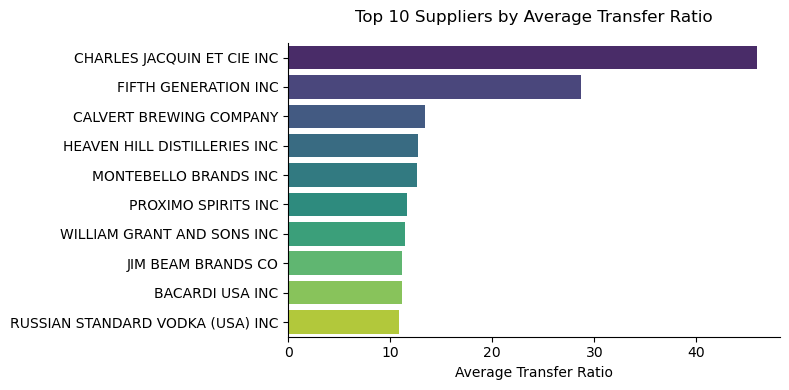

In [32]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=top_transfers,
    x='Transfer Ratio',
    y='Supplier',
    palette='viridis'
)

plt.title('Top 10 Suppliers by Average Transfer Ratio', pad=15)
plt.xlabel('Average Transfer Ratio')
plt.ylabel('')


sns.despine()
plt.tight_layout()
plt.show()

#### **Key Insights:**

This bar chart shows the **Top 10 Suppliers by Average Transfer Ratio**, highlighting which suppliers have the highest average transfer ratios. Here are the key observations:

---

#### **1. FIFTH GENERATION INC Leads Significantly**
- **Average Transfer Ratio**: Approximately **31**.
- **Insight**: FIFTH GENERATION INC has the highest average transfer ratio among all suppliers, indicating that a large portion of their products are being transferred (likely from warehouses to retail locations or other channels). This suggests:
  - Efficient inventory management and high demand for their products.
  - Strong alignment between wholesale and retail operations.

#### **2. PROXIMO SPIRITS INC and JIM BEAM BRANDS CO Follow Closely**
- **PROXIMO SPIRITS INC**: Average transfer ratio around **20**.
- **JIM BEAM BRANDS CO**: Average transfer ratio around **17**.
- **Insight**: These suppliers also demonstrate strong performance in terms of product transfers. Their high transfer ratios suggest:
  - Consistent demand for their products across different channels.
  - Effective supply chain management to ensure timely delivery to retail locations.

#### **3. Middle-Ranking Suppliers Show Moderate Performance**
- **HEAVEN HILL DISTILLERIES INC**, **DIAGEO NORTH AMERICA INC**, and **SAZERAC CO** have average transfer ratios ranging from **15 to 17**.
- **DISARONNO INTERNATIONAL LLC** and **WILLIAM GRANT AND SONS INC** have slightly lower ratios, around **14**.
- **Insight**: These suppliers maintain a balanced performance, indicating steady demand and efficient inventory flow. However, they may not be as dominant as the top performers.

#### **4. BACARDI USA INC and CAMPARI AMERICA LLC Lag Behind**
- **BACARDI USA INC**: Average transfer ratio around **13**.
- **CAMPARI AMERICA LLC**: Average transfer ratio around **12**.
- **Insight**: These suppliers have the lowest transfer ratios among the top 10. This could indicate:
  - Lower demand for their products compared to others.
  - Potential inefficiencies in inventory management or distribution processes.
  - A focus on direct-to-consumer sales rather than wholesale transfers.

---

## Warehouse Sales, Retail Sales and Retail Transfers Correlation

Now, let's analyze the correlation between Warehouse Sales, Retail Sales and Retail Transfer to see how strongly each pair of variables is related, for example if increases in warehouse sales are associated with increases in retail transfers.

In [33]:
corr = df[['Retail Sales', 'Warehouse Sales', 'Retail Transfers']].corr()

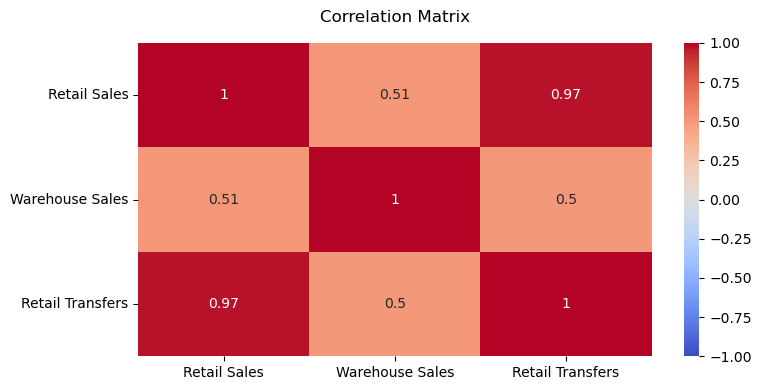

In [34]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    data=corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1
)

plt.title('Correlation Matrix', pad=15)
plt.tight_layout()
plt.show()


### **Key Insights:**

This correlation matrix provides a clear understanding of the relationships between **Retail Sales**, **Warehouse Sales**, and **Retail Transfers**. Here’s a breakdown of the key observations:

---

#### **1. Strong Positive Correlation Between Retail Sales and Retail Transfers**
- **Correlation Coefficient**: **0.97**
- **Interpretation**: There is a **very strong positive relationship** between retail sales and retail transfers. This suggests that:
  - When retail transfers increase, retail sales tend to increase as well.
  - Retail transfers are likely a significant driver of retail sales.

#### **2. Moderate Positive Correlation Between Warehouse Sales and Retail Sales**
- **Correlation Coefficient**: **0.51**
- **Interpretion**: There is a **moderate positive relationship** between warehouse sales and retail sales. This indicates:
  - As warehouse sales increase, retail sales also tend to increase, but not as strongly as with retail transfers.
  - Wholesale activity (warehouse sales) may indirectly influence retail performance.

#### **3. Moderate Positive Correlation Between Warehouse Sales and Retail Transfers**
- **Correlation Coefficient**: **0.50**
- **Interpretation**: Similar to the relationship between warehouse sales and retail sales, there is a **moderate positive relationship** between warehouse sales and retail transfers. This suggests:
  - Wholesale activity (warehouse sales) may lead to increased retail transfers, which in turn drive retail sales.

---